In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

# Set seed for reproducable results
sn.config.seed = 42

In [6]:
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 4
NUM_STREAMS_PER_TX = NUM_UT_ANT
RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])

CARRIER_FREQUENCY = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single",
                                        polarization_type="V",
                                        antenna_pattern="38.901",
                                        carrier_frequency=CARRIER_FREQUENCY)

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1,
                                            num_cols=int(NUM_BS_ANT/2),
                                            polarization="dual",
                                            polarization_type="cross",
                                            antenna_pattern="38.901", # Try 'omni'
                                            carrier_frequency=CARRIER_FREQUENCY)


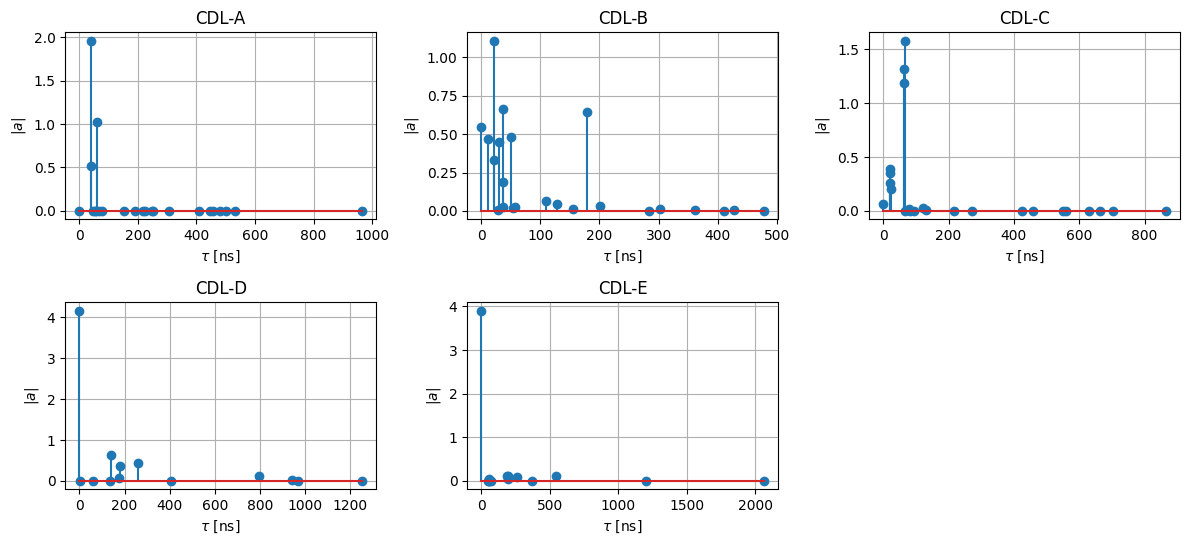

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sionna as sn

# Define CDL models
CDL_MODELS = ["A", "B", "C", "D", "E"]
DELAY_SPREAD = 100e-9  # Nominal delay spread in [s]
DIRECTION = "uplink"
SPEED = 20.0  # UT speed [m/s]

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle("")

# Define subplot positions for each CDL model
subplot_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]  # (1,2) will remain empty

for i, (cdl_model, pos) in enumerate(zip(CDL_MODELS, subplot_positions)):
    row, col = pos
    ax = axes[row, col]

    # Configure CDL channel
    CDL = sn.channel.tr38901.CDL(cdl_model,
                                 DELAY_SPREAD,
                                 CARRIER_FREQUENCY,
                                 UT_ARRAY,
                                 BS_ARRAY,
                                 DIRECTION,
                                 min_speed=SPEED)

    # Generate channel response
    a, tau = CDL(batch_size=BATCH_SIZE,
                 num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
                 sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)

    # Plot impulse response for this CDL model
    ax.stem(tau[0,0,0,:] / 1e-9, np.abs(a)[0,0,0,0,0,:,0], markerfmt="o")
    ax.set_title(f"CDL-{cdl_model}")
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.grid()

# Hide the empty subplot (bottom-right)
axes[1, 2].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.savefig("cdl_realizations_20ms.png", dpi=300, bbox_inches='tight')
plt.show()


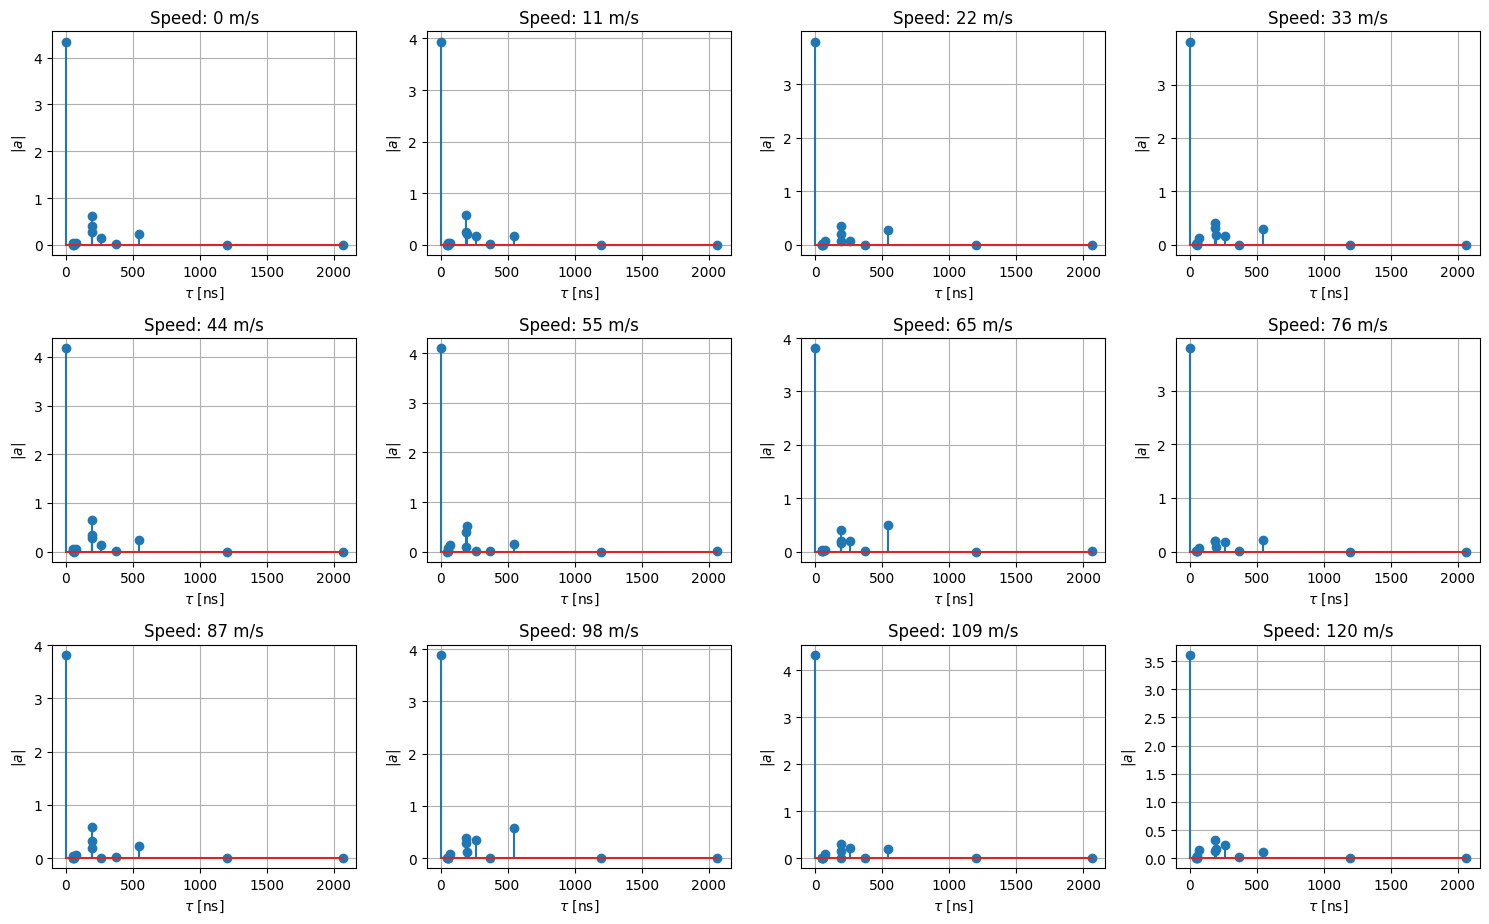

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import sionna as sn

# Define speed values from 0 to 120 in increments of 10
SPEED_VALUES = np.linspace(0, 120, 12)

DELAY_SPREAD = 100e-9  # Nominal delay spread in [s]
DIRECTION = "uplink"
CDL_MODEL = "E"  # Fixed CDL model
BATCH_SIZE = 128  # How many examples are processed in parallel

# Create a figure with a 3-row, 4-column grid for subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("")

# Iterate through different speed values and plot in separate subplots
for i, speed in enumerate(SPEED_VALUES):
    row, col = divmod(i, 4)  # Compute subplot row and column indices
    ax = axes[row, col]

    # Configure CDL channel with varying speed
    CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                                 DELAY_SPREAD,
                                 CARRIER_FREQUENCY,
                                 UT_ARRAY,
                                 BS_ARRAY,
                                 DIRECTION,
                                 min_speed=speed)

    # Generate channel response
    a, tau = CDL(batch_size=BATCH_SIZE,
                 num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
                 sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)

    # Plot impulse response for this speed
    ax.stem(tau[0,0,0,:] / 1e-9, np.abs(a)[0,0,0,0,0,:,0], markerfmt="o")
    ax.set_title(f"Speed: {speed:.0f} m/s")
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.grid()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.savefig(f"cdl_{CDL_MODEL}_speed.png", dpi=300, bbox_inches='tight')
plt.show()


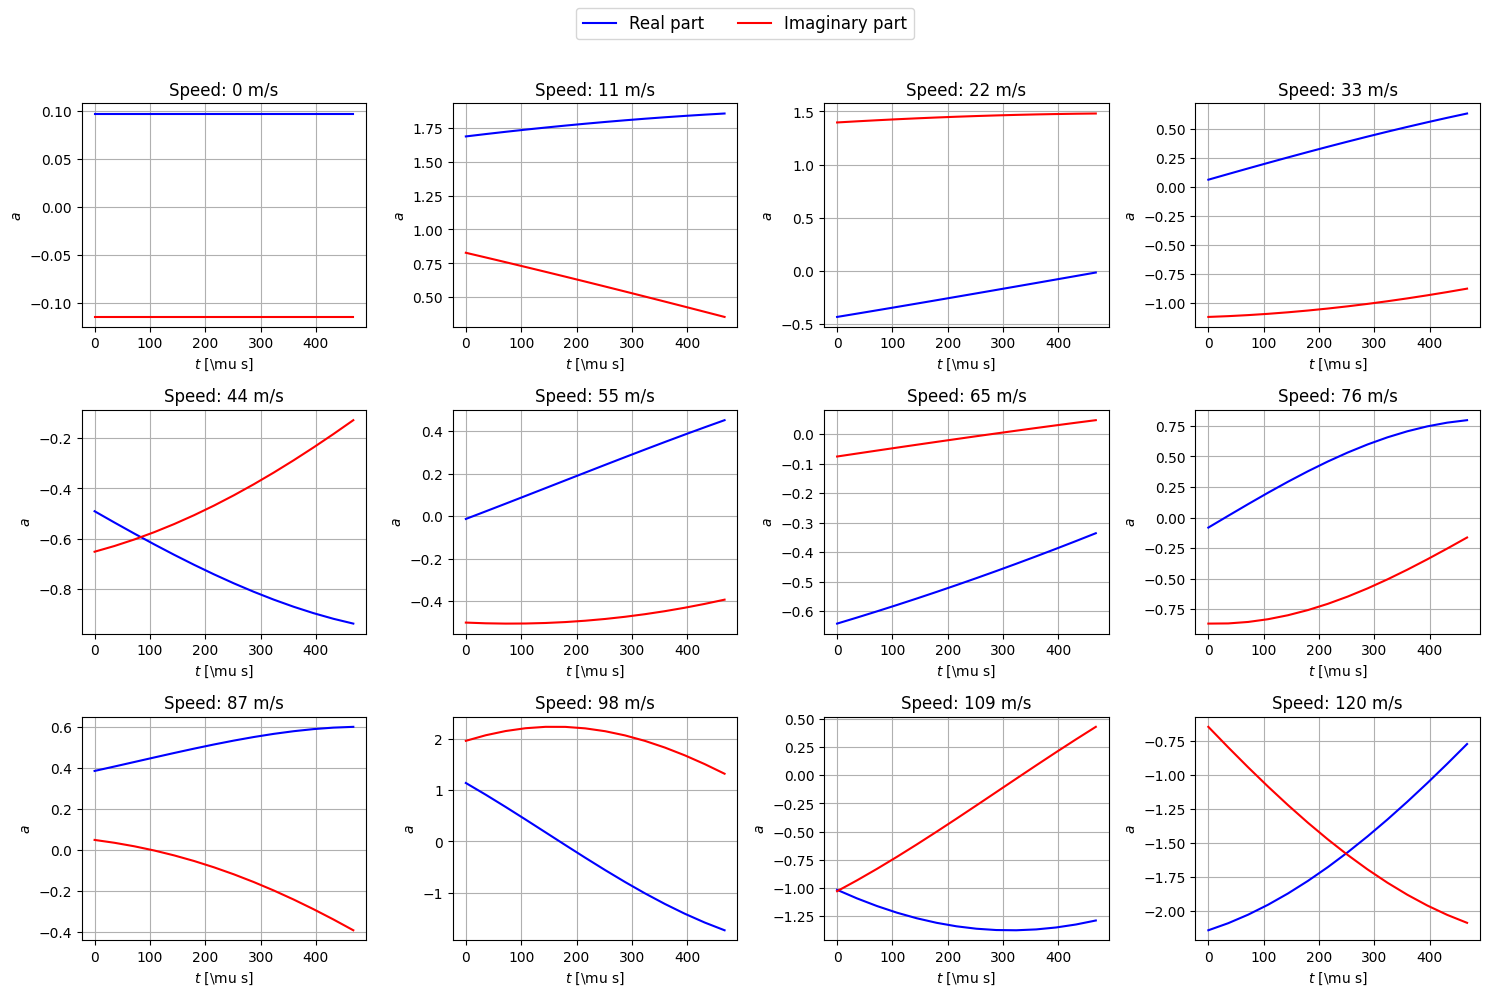

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import sionna as sn

# Define speed values from 0 to 120 in increments of 10
SPEED_VALUES = np.linspace(0, 120, 12)

DELAY_SPREAD = 100e-9  # Nominal delay spread in [s]
DIRECTION = "uplink"
CDL_MODEL = "B"  # Fixed CDL model
BATCH_SIZE = 128  # How many examples are processed in parallel

# Create a figure with a 3-row, 4-column grid for subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("")

# Iterate through different speed values and plot in separate subplots
for i, speed in enumerate(SPEED_VALUES):
    row, col = divmod(i, 4)  # Compute subplot row and column indices
    ax = axes[row, col]

    # Configure CDL channel with varying speed
    CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                                 DELAY_SPREAD,
                                 CARRIER_FREQUENCY,
                                 UT_ARRAY,
                                 BS_ARRAY,
                                 DIRECTION,
                                 min_speed=speed)

    # Generate channel response
    a, tau = CDL(batch_size=BATCH_SIZE,
                 num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
                 sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)

    # Time vector
    t_us = np.arange(RESOURCE_GRID.num_ofdm_symbols) * RESOURCE_GRID.ofdm_symbol_duration / 1e-6

    # Plot time evolution of path gain
    ax.plot(t_us, np.real(a)[0,0,0,0,0,0,:], label="Real part", color='b')
    ax.plot(t_us, np.imag(a)[0,0,0,0,0,0,:], label="Imaginary part", color='r')

    ax.set_title(f"Speed: {speed:.0f} m/s")
    ax.set_xlabel(r"$t$ [\mu s]")
    ax.set_ylabel(r"$a$")
    ax.grid()

# Add a **single common legend** outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title and legend
plt.savefig(f"CDL_B_time_evolution_with_speed.png", dpi=300, bbox_inches='tight')
plt.show()
